In [16]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [23]:
class Config:
    # Paths
    DATA_DIR = '/Users/sreethanubhuvaneshgk/Downloads/desktop/home_folder/lung-cancer-detection/data/raw/subset0'  # Path to LUNA16 subset0 folder
    ANNOTATIONS_FILE = '/Users/sreethanubhuvaneshgk/Downloads/desktop/home_folder/lung-cancer-detection/data/annotations/annotations.csv'  # Path to annotations CSV
    
    # Preprocessing
    IMG_SIZE = 224  # Input size for pre-trained models
    PATCH_SIZE = 64  # Size of 3D patch to extract around nodule
    HU_MIN = -1000  # Hounsfield Unit windowing
    HU_MAX = 400
    
    # Training
    BATCH_SIZE = 16
    NUM_EPOCHS = 50
    LEARNING_RATE = 0.0001
    TRAIN_SPLIT = 0.8
    NUM_WORKERS = 0  # Set to 0 for Jupyter notebooks, increase for .py scripts
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Model
    PRETRAINED_MODEL = 'resnet50'  # Options: resnet50, resnet101, densenet121, efficientnet_b0
    NUM_CLASSES = 2  # Binary: cancer/no-cancer or nodule/non-nodule

config = Config()

In [24]:
# ============================================================================
# DATA PREPROCESSING
# ============================================================================
def load_itk_image(filename):
    """Load CT scan using SimpleITK"""
    itkimage = sitk.ReadImage(filename)
    ct_scan = sitk.GetArrayFromImage(itkimage)
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    return ct_scan, origin, spacing

def normalize_hu(image):
    """Normalize Hounsfield Units"""
    image = np.clip(image, config.HU_MIN, config.HU_MAX)
    image = (image - config.HU_MIN) / (config.HU_MAX - config.HU_MIN)
    return image

def world_to_voxel(world_coords, origin, spacing):
    """Convert world coordinates to voxel coordinates"""
    stretched_voxel = np.absolute(world_coords - origin)
    voxel = stretched_voxel / spacing
    return voxel.astype(int)

def extract_nodule_patch(ct_scan, center, patch_size=64):
    """Extract 3D patch around nodule center"""
    z, y, x = center
    half_size = patch_size // 2
    
    z_start = max(0, z - half_size)
    z_end = min(ct_scan.shape[0], z + half_size)
    y_start = max(0, y - half_size)
    y_end = min(ct_scan.shape[1], y + half_size)
    x_start = max(0, x - half_size)
    x_end = min(ct_scan.shape[2], x + half_size)
    
    patch = ct_scan[z_start:z_end, y_start:y_end, x_start:x_end]
    
    # Pad if necessary
    if patch.shape != (patch_size, patch_size, patch_size):
        padded = np.zeros((patch_size, patch_size, patch_size))
        padded[:patch.shape[0], :patch.shape[1], :patch.shape[2]] = patch
        patch = padded
    
    return patch

def create_2d_projection(patch_3d):
    """Create 2D projection from 3D patch for 2D CNN"""
    # Maximum Intensity Projection (MIP) along z-axis
    mip = np.max(patch_3d, axis=0)
    
    # Resize to model input size
    from scipy.ndimage import zoom
    zoom_factor = config.IMG_SIZE / mip.shape[0]
    resized = zoom(mip, zoom_factor, order=1)
    
    # Convert to 3-channel (RGB) for pre-trained models
    rgb_image = np.stack([resized] * 3, axis=0)
    
    return rgb_image

def preprocess_luna16_data(data_dir, annotations_file):
    """Preprocess LUNA16 data and extract nodule patches"""
    print("Loading annotations...")
    annotations = pd.read_csv(annotations_file)
    
    # LUNA16 annotations format: seriesuid, coordX, coordY, coordZ, diameter_mm
    samples = []
    labels = []
    
    print(f"Processing {len(annotations)} annotations...")
    
    for idx, row in tqdm(annotations.iterrows(), total=len(annotations)):
        try:
            series_uid = row['seriesuid']
            coord_x, coord_y, coord_z = row['coordX'], row['coordY'], row['coordZ']
            
            # Find corresponding .mhd file
            ct_file = os.path.join(data_dir, f"{series_uid}.mhd")
            
            if not os.path.exists(ct_file):
                continue
            
            # Load CT scan
            ct_scan, origin, spacing = load_itk_image(ct_file)
            
            # Convert world coordinates to voxel coordinates
            world_coords = np.array([coord_z, coord_y, coord_x])
            voxel_coords = world_to_voxel(world_coords, origin, spacing)
            
            # Extract patch
            patch_3d = extract_nodule_patch(ct_scan, voxel_coords, config.PATCH_SIZE)
            
            # Normalize
            patch_3d = normalize_hu(patch_3d)
            
            # Create 2D projection
            patch_2d = create_2d_projection(patch_3d)
            
            samples.append(patch_2d)
            
            # Label (if you have malignancy info, use it; otherwise binary nodule detection)
            # For LUNA16, you might need candidates.csv for actual labels
            label = 1  # Assuming all annotations are positive nodules
            labels.append(label)
            
        except Exception as e:
            print(f"Error processing {series_uid}: {str(e)}")
            continue
    
    print(f"\nSuccessfully processed {len(samples)} samples")
    
    return np.array(samples), np.array(labels)


In [25]:
# ============================================================================
# DATASET CLASS
# ============================================================================
class LungNoduleDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert to tensor
        image = torch.FloatTensor(image)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label



In [26]:
# ============================================================================
# MODEL DEFINITION
# ============================================================================
class LungCancerClassifier(nn.Module):
    def __init__(self, model_name='resnet50', num_classes=2, pretrained=True):
        super(LungCancerClassifier, self).__init__()
        
        if model_name == 'resnet50':
            self.backbone = models.resnet50(pretrained=pretrained)
            num_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
            
        elif model_name == 'resnet101':
            self.backbone = models.resnet101(pretrained=pretrained)
            num_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
            
        elif model_name == 'densenet121':
            self.backbone = models.densenet121(pretrained=pretrained)
            num_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            
        elif model_name == 'efficientnet_b0':
            self.backbone = models.efficientnet_b0(pretrained=pretrained)
            num_features = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()
        
        # Custom classifier head
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)
        return output

In [27]:
# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(dataloader, desc='Training'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs



Using device: cpu

1. PREPROCESSING DATA
Loading annotations...
Processing 1186 annotations...


100%|██████████| 1186/1186 [00:13<00:00, 85.82it/s] 



Successfully processed 112 samples

2. SPLITTING DATA
Training samples: 89
Validation samples: 23

3. CREATING DATALOADERS

4. INITIALIZING MODEL
Model: resnet50
Total parameters: 24,688,962

5. TRAINING MODEL

Epoch 1/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.3959 | Train Acc: 97.75%
Val Loss: 0.2811 | Val Acc: 100.00%
✓ Best model saved with Val Acc: 100.00%

Epoch 2/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Train Loss: 0.0937 | Train Acc: 100.00%
Val Loss: 0.0851 | Val Acc: 100.00%

Epoch 3/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Train Loss: 0.0165 | Train Acc: 100.00%
Val Loss: 0.0149 | Val Acc: 100.00%

Epoch 4/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Train Loss: 0.0026 | Train Acc: 100.00%
Val Loss: 0.0029 | Val Acc: 100.00%

Epoch 5/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0009 | Train Acc: 100.00%
Val Loss: 0.0008 | Val Acc: 100.00%

Epoch 6/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%

Epoch 7/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Train Loss: 0.0002 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%

Epoch 8/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Train Loss: 0.0002 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%

Epoch 9/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 10/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 11/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Train Loss: 0.0001 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 12/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 13/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 14/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 15/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 16/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 17/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 18/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 19/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 20/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 21/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 22/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 23/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 24/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 25/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 26/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 27/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 28/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 29/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 30/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 31/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 32/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 33/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 34/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 35/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 36/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 37/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 38/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 39/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 40/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 41/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 42/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 43/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 44/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 45/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 46/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 47/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 48/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 49/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 50/50
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Train Loss: 0.0000 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%

6. FINAL EVALUATION


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]



Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        23

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23


Confusion Matrix:
[[23]]

ROC-AUC Score: nan

✓ Training history saved to 'training_history.png'

TRAINING COMPLETE!


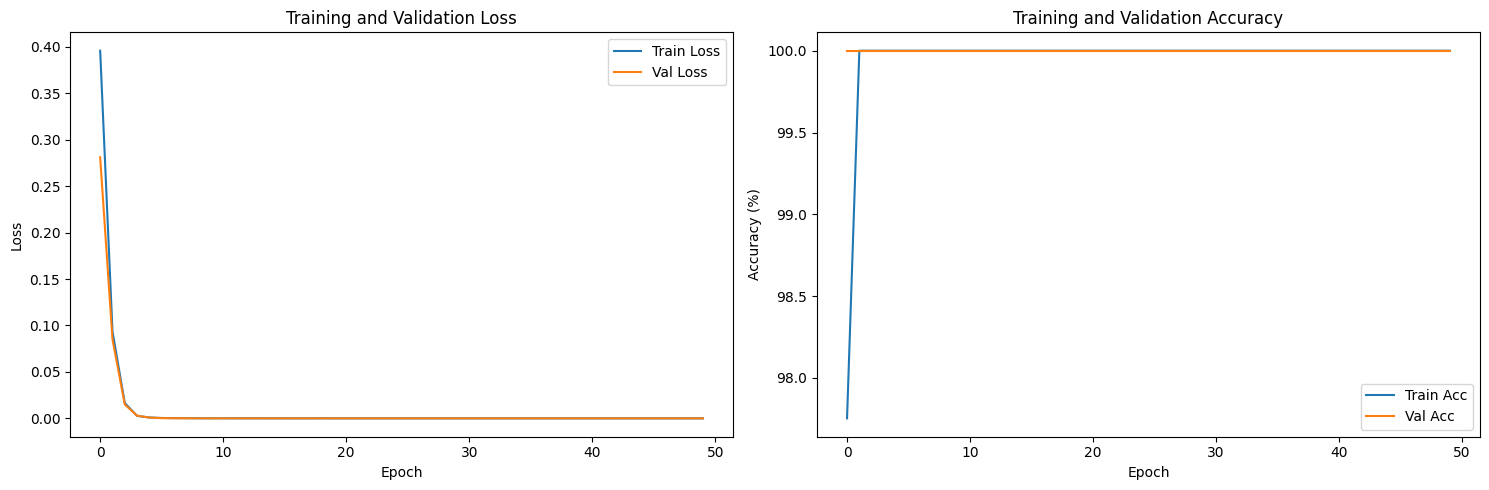

In [28]:
# ============================================================================
# MAIN TRAINING PIPELINE
# ============================================================================
def main():
    print(f"Using device: {config.DEVICE}")
    print("="*80)
    
    # Step 1: Preprocess data
    print("\n1. PREPROCESSING DATA")
    print("="*80)
    images, labels = preprocess_luna16_data(config.DATA_DIR, config.ANNOTATIONS_FILE)
    
    # Step 2: Split data
    print("\n2. SPLITTING DATA")
    print("="*80)
    X_train, X_val, y_train, y_val = train_test_split(
        images, labels, 
        test_size=1-config.TRAIN_SPLIT, 
        random_state=42,
        stratify=labels
    )
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    
    # Step 3: Create datasets and dataloaders
    print("\n3. CREATING DATALOADERS")
    print("="*80)
    
    # Data augmentation for training
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
    ])
    
    train_dataset = LungNoduleDataset(X_train, y_train, transform=train_transform)
    val_dataset = LungNoduleDataset(X_val, y_val)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=True, 
        num_workers=config.NUM_WORKERS
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=False, 
        num_workers=config.NUM_WORKERS
    )
    
    # Step 4: Initialize model
    print("\n4. INITIALIZING MODEL")
    print("="*80)
    model = LungCancerClassifier(
        model_name=config.PRETRAINED_MODEL, 
        num_classes=config.NUM_CLASSES,
        pretrained=True
    ).to(config.DEVICE)
    
    print(f"Model: {config.PRETRAINED_MODEL}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Step 5: Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    # Step 6: Training loop
    print("\n5. TRAINING MODEL")
    print("="*80)
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_acc = 0.0
    
    for epoch in range(config.NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")
        print("-"*80)
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE)
        val_loss, val_acc, val_preds, val_labels, val_probs = validate_epoch(
            model, val_loader, criterion, config.DEVICE
        )
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        scheduler.step(val_loss)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, 'best_lung_cancer_model.pth')
            print(f"✓ Best model saved with Val Acc: {val_acc:.2f}%")
    
    # Step 7: Final evaluation
    print("\n6. FINAL EVALUATION")
    print("="*80)
    
    # Load best model
    checkpoint = torch.load('best_lung_cancer_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Evaluate
    _, _, val_preds, val_labels, val_probs = validate_epoch(
        model, val_loader, criterion, config.DEVICE
    )
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(val_labels, val_preds))
    
    # Confusion matrix
    cm = confusion_matrix(val_labels, val_preds)
    print("\nConfusion Matrix:")
    print(cm)
    
    # ROC-AUC if binary classification
    if config.NUM_CLASSES == 2:
        auc = roc_auc_score(val_labels, val_probs)
        print(f"\nROC-AUC Score: {auc:.4f}")
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    print("\n✓ Training history saved to 'training_history.png'")
    
    print("\n" + "="*80)
    print("TRAINING COMPLETE!")
    print("="*80)

if __name__ == "__main__":
    main()